## Glider mapping with z


In [1]:
from scipy.io import loadmat
import numpy as np
import xarray as xr

import glidertools as gt
import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm

from cmocean import cm as cmo

import gsw

import gpytorch
import torch

import sys
sys.path.append('../../../python_packages/PyTorch-LBFGS/functions/')
from LBFGS import FullBatchLBFGS

In [2]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660/CTD_660.nc'

In [3]:
ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

In [4]:
dens_659 = gsw.sigma0(ds_659.salinity, ds_659.temperature)
dens_660 = gsw.sigma0(ds_660.salinity, ds_660.temperature)
ds_659['density'] = xr.DataArray(
            data=dens_659,
            coords=ds_659.coords,
            dims=ds_659.dims,
            name='density'
        )

ds_660['density'] = xr.DataArray(
            data=dens_660,
            coords=ds_660.coords,
            dims=ds_660.dims,
            name='density'
        )

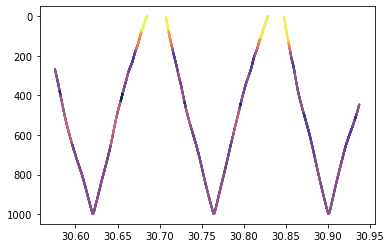

In [121]:
npts_start = 10000
npts_end = 20000

ds_659_sel= ds_659.isel(ctd_data_point=slice(npts_start, npts_end))

plt.scatter(ds_659_sel.longitude, ds_659_sel.pressure, 
            c = ds_659_sel.temperature, s=1, cmap=cmo.thermal)

plt.gca().invert_yaxis()

In [48]:
def great_circle_distance(lon1, lat1, lon2, lat2):
    """Calculate the great circle distance between one or multiple pairs of
    points given in spherical coordinates. Spherical coordinates are expected
    in degrees. Angle definition follows standard longitude/latitude definition.
    This uses the arctan version of the great-circle distance function
    (en.wikipedia.org/wiki/Great-circle_distance) for increased
    numerical stability.
    Parameters
    ----------
    lon1: float scalar or numpy array
        Longitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lat1: float scalar or numpy array
        Latitude coordinate(s) of the first element(s) of the point
        pair(s), given in degrees.
    lon2: float scalar or numpy array
        Longitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    lat2: float scalar or numpy array
        Latitude coordinate(s) of the second element(s) of the point
        pair(s), given in degrees.
    Calculation of distances follows numpy elementwise semantics, so if
    an array of length N is passed, all input parameters need to be
    arrays of length N or scalars.
    Returns
    -------
    distance: float scalar or numpy array
        The great circle distance(s) (in degrees) between the
        given pair(s) of points.
    """
    # Convert to radians:
    lat1 = np.array(lat1) * np.pi / 180.0
    lat2 = np.array(lat2) * np.pi / 180.0
    dlon = (lon1 - lon2) * np.pi / 180.0

    # Evaluate trigonometric functions that need to be evaluated more
    # than once:
    c1 = np.cos(lat1)
    s1 = np.sin(lat1)
    c2 = np.cos(lat2)
    s2 = np.sin(lat2)
    cd = np.cos(dlon)

    # This uses the arctan version of the great-circle distance function
    # from en.wikipedia.org/wiki/Great-circle_distance for increased
    # numerical stability.
    # Formula can be obtained from [2] combining eqns. (14)-(16)
    # for spherical geometry (f=0).

    return (
        180.0
        / np.pi
        * np.arctan2(
            np.sqrt((c2 * np.sin(dlon)) ** 2 + (c1 * s2 - s1 * c2 * cd) ** 2),
            s1 * s2 + c1 * c2 * cd,
        )
    )

In [49]:
origin_lat = -53.5 #S
origin_lon = 29.5  #E

X_659 = great_circle_distance(origin_lon, ds_659_sel.latitude, 
                          ds_659_sel.longitude, ds_659_sel.latitude)*110
Y_659 = great_circle_distance(ds_659_sel.longitude, origin_lat, 
                          ds_659_sel.longitude, ds_659_sel.latitude)*110

In [50]:
time_659 = ds_659_sel.time - np.datetime64('2019-01-01')
time_659 = (time_659 / np.timedelta64(1,'D'))

In [51]:
pressure_659 = ds_659_sel.pressure

In [52]:
density_659 = ds_659_sel.density

(26.5, 27.8)

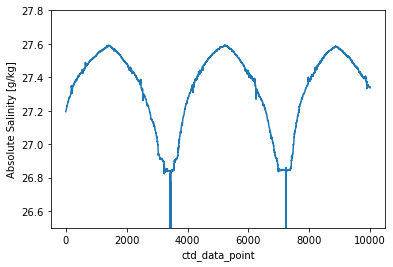

In [53]:
density_659.plot()
plt.ylim([26.5, 27.8])

In [63]:
#x = np.zeros((len(time_659), 4))

# coordinates of samples 
#x[:,0] = time_659.values
#x[:,1] = X_659.values
#x[:,2] = Y_659.values
#x[:,3] = pressure_659.values

#x_xarr = xr.DataArray(x, dims=['sample_num','coordinate'], 
#                     coords=[range(len(time_659)), ['t','x','y','z']])

x = np.zeros((len(time_659), 3))

# coordinates of samples 
#x[:,0] = time_659.values
x[:,0] = X_659.values
x[:,1] = Y_659.values
x[:,2] = pressure_659.values

x_xarr = xr.DataArray(x, dims=['sample_num','coordinate'], 
                     coords=[range(len(time_659)), ['x','y','z']])


y = density_659.values


y_xarr = xr.DataArray(y, dims=['sample_num'],
                     coords=[range(len(time_659))])

In [64]:
x_xarr_nonans = x_xarr.where(~np.isnan(y_xarr), drop=True
                            )#.where(~np.isnan(x_xarr[:,3]), drop=True)
y_xarr_nonans = y_xarr.where(~np.isnan(y_xarr), drop=True
                            )#.where(~np.isnan(x_xarr[:,3]), drop=True)

In [147]:
x_xarr_nonans_sel = x_xarr_nonans.where(x_xarr_nonans.sel(coordinate='z')<300, drop=True
                                       ).where(x_xarr_nonans.sel(coordinate='z')>150, drop=True)
y_xarr_nonans_sel = y_xarr_nonans.where(x_xarr_nonans.sel(coordinate='z')<300, drop=True
                                       ).where(x_xarr_nonans.sel(coordinate='z')>150, drop=True)

In [149]:
y_xarr_nonans_sel

<xarray.DataArray (sample_num: 1247)>
array([27.19520998, 27.19544954, 27.19779199, ..., 27.1892858 ,
       27.18887376, 27.1888263 ])
Coordinates:
  * sample_num  (sample_num) int64 0 1 2 3 4 5 ... 7641 7642 7643 7644 7645 7646
    coordinate  <U1 'z'

In [150]:
# convert to torch tensors, since that is what PyTorch and GPyTorch work with.
train_x = torch.from_numpy(x_xarr_nonans_sel.values).float()
train_y = torch.from_numpy(y_xarr_nonans_sel.values).float()

In [151]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP): # setup the class which inherits the ExactGP model
    # initialize the class with X_input, Y_input and a likelihood
    def __init__(self, train_x, train_y, likelihood):
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # This calls the __init__ of the inherited class (gpytorch.models.ExactGP),
        # and passes the training data and a likelihood to it.
        # Also ExactGPModel objects have access to 'ExactGP' functions, since it has inherited it.
        
        # Chose a constant mean.
        self.mean_module = gpytorch.means.ConstantMean()
        # ScaleKernel gives the covariance function a scaling factor (K_scale = theta*K_orig)
        self.covar_module = gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.RBFKernel(ard_num_dims=3, 
                                                       has_lengthscale=True))#train_x.shape[1])) 
                                        #,lengthscale_prior=[0.5, 0.5, 0.5]))

        # forward takes some x input of size nXd (n-num samples, d-input dim),
        # and returns the multivariate gaussian with mu(x) and cov(x)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [152]:
# initialize likelihood and model
#likelihood_adam = gpytorch.likelihoods.GaussianLikelihood()
likelihood_lbfgs = gpytorch.likelihoods.GaussianLikelihood()
#model_adam = ExactGPModel(train_x, train_y, likelihood_adam)
model_lbfgs = ExactGPModel(train_x, train_y, likelihood_lbfgs)

In [153]:
hypers = {
    'likelihood.noise_covar.noise': torch.tensor(.1),
    'covar_module.base_kernel.lengthscale': torch.tensor([10., 10., 10.]),
    'covar_module.outputscale': torch.tensor(10.),
}
model_lbfgs.initialize(**hypers);
#model_lbfgs.initialize(**hypers);

Iter 1/50 - Loss: -0.543 - LR: 16.000 - Func Evals: 5 - Grad Evals: 5 - Log-Lengthscale: 10.200 - Log_Noise: 0.000
Iter 2/50 - Loss: -0.654 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 10.565 - Log_Noise: 0.000
Iter 3/50 - Loss: -0.707 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 10.730 - Log_Noise: 0.000
Iter 4/50 - Loss: -0.751 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 11.703 - Log_Noise: 0.000
Iter 5/50 - Loss: -0.960 - LR: 1.000 - Func Evals: 1 - Grad Evals: 1 - Log-Lengthscale: 11.257 - Log_Noise: 0.000
Iter 6/50 - Loss: -0.893 - LR: 0.000 - Func Evals: 12 - Grad Evals: 1 - Log-Lengthscale: 11.257 - Log_Noise: 0.000
Iter 7/50 - Loss: -0.958 - LR: 0.040 - Func Evals: 3 - Grad Evals: 1 - Log-Lengthscale: 11.274 - Log_Noise: 0.000
Iter 8/50 - Loss: -0.964 - LR: 0.000 - Func Evals: 7 - Grad Evals: 1 - Log-Lengthscale: 11.274 - Log_Noise: 0.000
Iter 9/50 - Loss: -0.859 - LR: 0.000 - Func Evals: 12 - Grad Evals: 1 - Log-Lengthscal

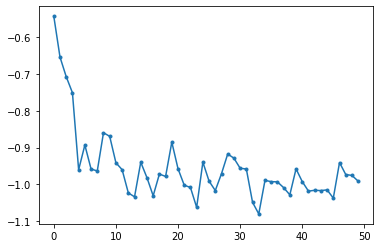

In [154]:
# Find optimal model hyperparameters
model_lbfgs.train() 
likelihood_lbfgs.train();
# these calls set the model and likelihood into training modes 
# (they don't actually train anything)
# Use the adam optimizer
optimizer = FullBatchLBFGS(model_lbfgs.parameters())


# "Loss" for GPs - the marginal log likelihood log(p(y(x)))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood_lbfgs, model_lbfgs)

# define closure
def closure():
    optimizer.zero_grad()
    output = model_lbfgs(train_x)
    loss = -mll(output, train_y)
    return loss

loss = closure()
loss.backward()

training_iter = 50
loss_vals = np.zeros(training_iter)

for i in range(training_iter):

    # perform step and update curvature
    options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}
    loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(options)

#    print('Iter %d/%d - Loss: %.3f   lengthscale1: %.3f noise: %.3f' % (
#            i + 1, training_iter, loss.item(),
#            model.covar_module.base_kernel.lengthscale[0][0].item(),
#            model.likelihood.noise.item()
#              ))
    loss_vals[i] = loss.item()
    if np.mod(i,1)==0:
        print('Iter %d/%d - Loss: %.3f - LR: %.3f - Func Evals: %0.0f - Grad Evals: %0.0f - Log-Lengthscale: %.3f - Log_Noise: %.3f' % (
        i + 1, training_iter, loss.item(), lr, F_eval, G_eval,
        model_lbfgs.covar_module.base_kernel.lengthscale[0][0].item(),
        model_lbfgs.likelihood.noise.item()
        ))
    
plt.plot(loss_vals, marker='.')

In [165]:
print('Noise std: ', model_lbfgs.likelihood.noise_covar.noise.item()**0.5)
print('Scale kernel: ',model_lbfgs.covar_module.outputscale.item())
print('Length/time scales: ',model_lbfgs.covar_module.base_kernel.lengthscale)

Noise std:  0.010000001692678636
Scale kernel:  15.11044692993164
Length/time scales:  tensor([[11.7846,  7.0786, 17.3146]], grad_fn=<SoftplusBackward>)


Do the prediction step 

In [166]:
xmin = x_xarr_nonans_sel.sel(coordinate='x').min()
xmax = x_xarr_nonans_sel.sel(coordinate='x').max()
ymin = x_xarr_nonans_sel.sel(coordinate='y').min()
ymax = x_xarr_nonans_sel.sel(coordinate='y').max()

In [178]:
temp = np.array(np.meshgrid(
                    np.linspace(xmin, xmax, 10), 
                    np.linspace(ymin, ymax, 10),
                    np.linspace(150,300, 50))).reshape(3,-1)

In [204]:
test_pts1 = torch.from_numpy( temp.T).float()

In [202]:
test_pts2 = train_x

In [210]:
test_pts1_xr = xr.DataArray(test_pts1.numpy(),  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts1.shape[0]), ['x','y','z']] ) 
test_pts2_xr = xr.DataArray(test_pts2.numpy(),  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts2.shape[0]), ['x','y','z']] ) 

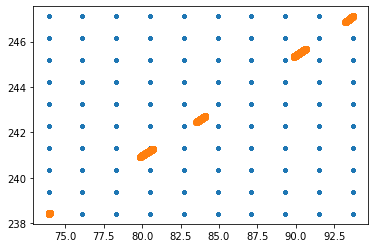

In [217]:
plt.plot(test_pts1_xr.sel(coordinate='x'), 
         test_pts1_xr.sel(coordinate='y'), '.'
         )

plt.plot(test_pts2_xr.sel(coordinate='x'), 
         test_pts2_xr.sel(coordinate='y'), 'o'
         )

In [208]:
test_pts1_xr

<xarray.DataArray (test_pt_num: 5000, coordinate: 3)>
array([[ 73.917984, 238.4122  , 150.      ],
       [ 73.917984, 238.4122  , 153.06122 ],
       [ 73.917984, 238.4122  , 156.12245 ],
       ...,
       [ 93.70989 , 247.11365 , 293.87756 ],
       [ 93.70989 , 247.11365 , 296.93878 ],
       [ 93.70989 , 247.11365 , 300.      ]], dtype=float32)
Coordinates:
  * test_pt_num  (test_pt_num) int64 0 1 2 3 4 5 ... 4995 4996 4997 4998 4999
  * coordinate   (coordinate) <U1 'x' 'y' 'z'

In [206]:
model_lbfgs.eval()
likelihood_lbfgs.eval();

In [207]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    observed_pred1 = likelihood_lbfgs(model_lbfgs(test_pts1))
    observed_pred2 = likelihood_lbfgs(model_lbfgs(test_pts2))

In [195]:
mean_obs = observed_pred1.mean
var_obs  = observed_pred.variance
samp1    = observed_pred.sample()

In [196]:
pred_mean = xr.DataArray(mean_obs.numpy(),  dims={"test_pt_num"})

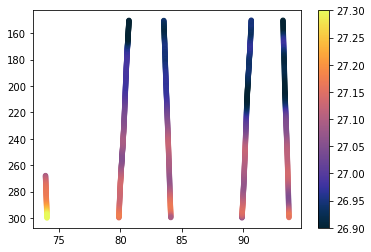

In [199]:
plt.scatter(test_pts_xr.sel(coordinate='x'), 
            test_pts_xr.sel(coordinate='z'), 
            c = mean_obs, s=20, cmap=cmo.thermal, vmin=26.9, vmax=27.3)

plt.gca().invert_yaxis()
plt.colorbar()

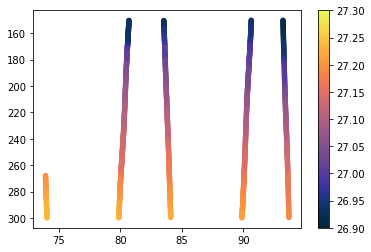

In [200]:
plt.scatter(x_xarr_nonans_sel.sel(coordinate='x'), 
            x_xarr_nonans_sel.sel(coordinate='z'), 
            c = y_xarr_nonans_sel, s=20, cmap=cmo.thermal, vmin=26.9, vmax=27.3)

plt.gca().invert_yaxis()
plt.colorbar()

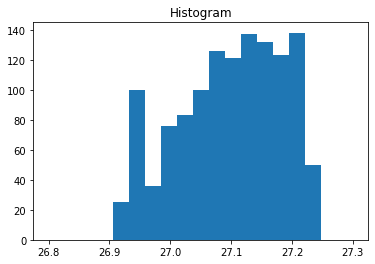

In [221]:
y_xarr_nonans_sel.plot.hist(bins=np.linspace(26.8,27.3,20));